In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import histogram
import os
os.makedirs('./plot', exist_ok=True)
RANDOM_SEED = 42
N_SYNTH_DATA = 1.4

254


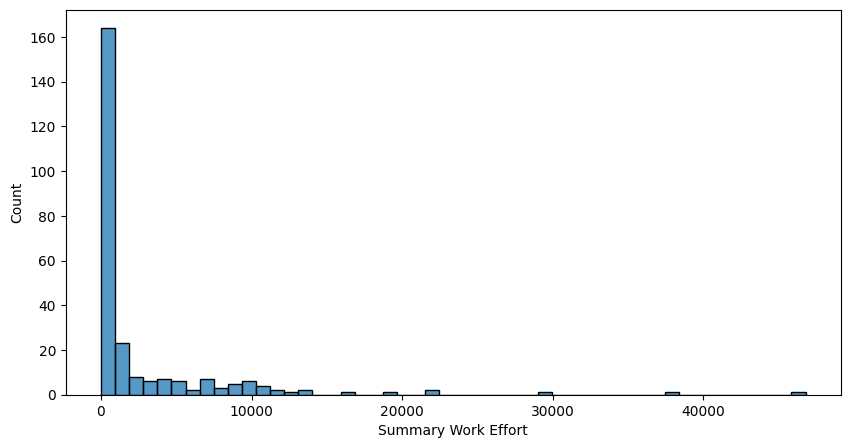

In [35]:
# Importing ISBG as dataframe
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)
# ISBG.set_index("Project ID", inplace=True)

cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
ISBG_interest.head()

df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry"])
print(len(df_clean))
plt.figure(figsize=(10,5))
sns.histplot(df_clean['Summary Work Effort'], kde=False, bins=50)  # Set bins and kde to False

df_clean = df_clean.dropna(subset=['Summary Work Effort'])

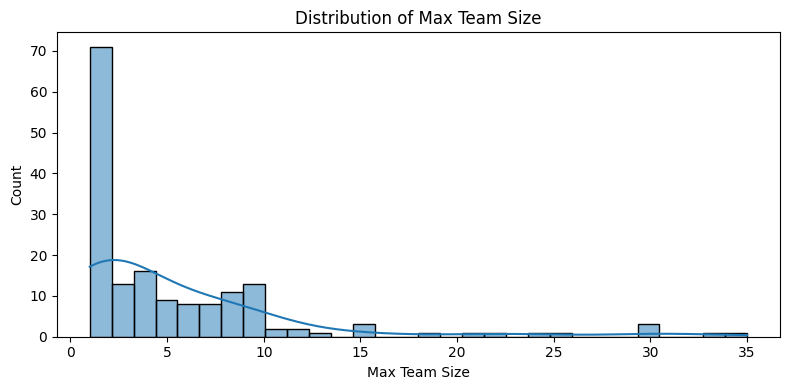

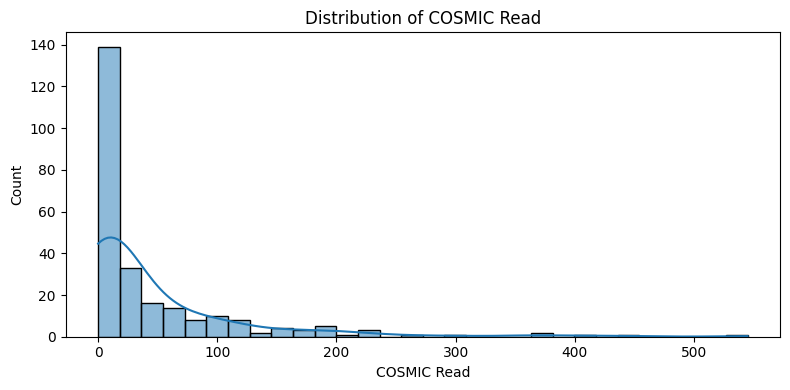

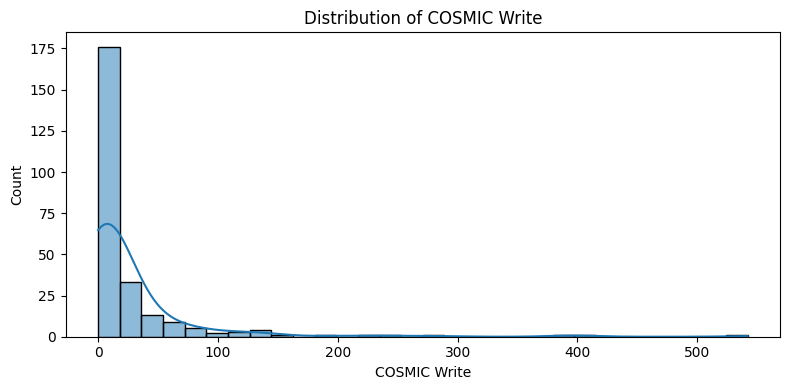

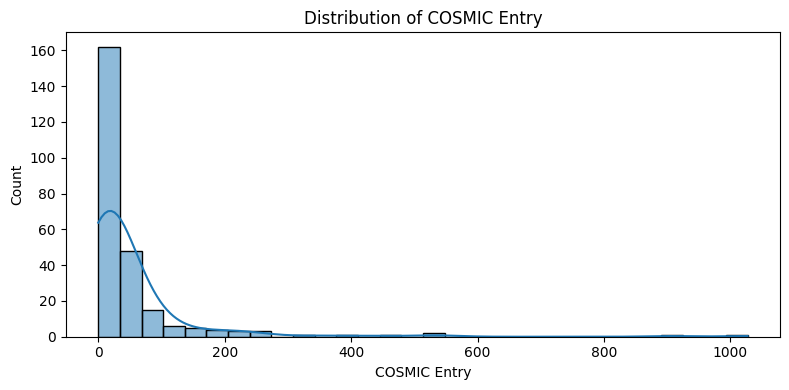

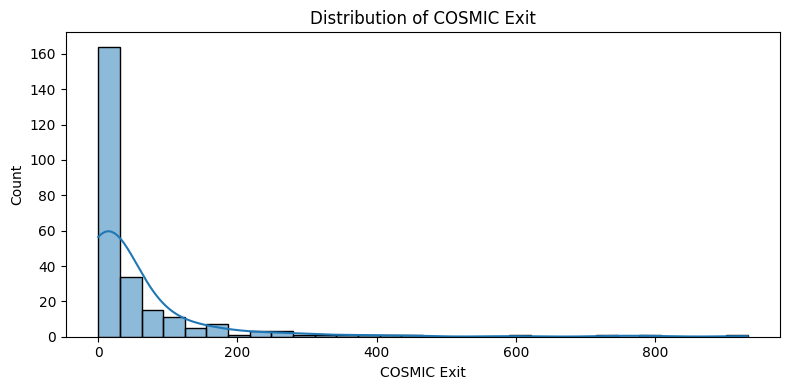

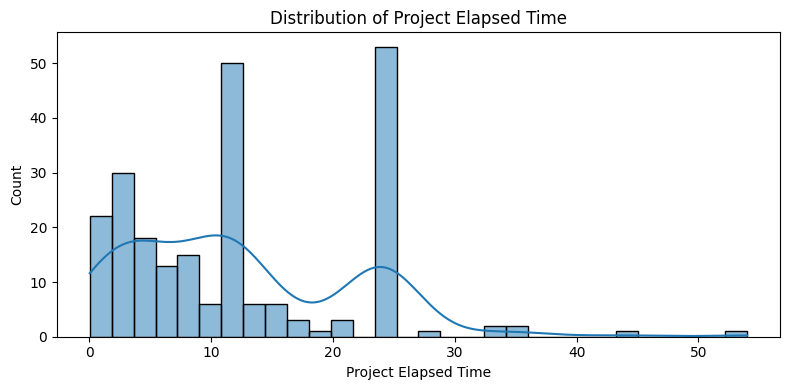

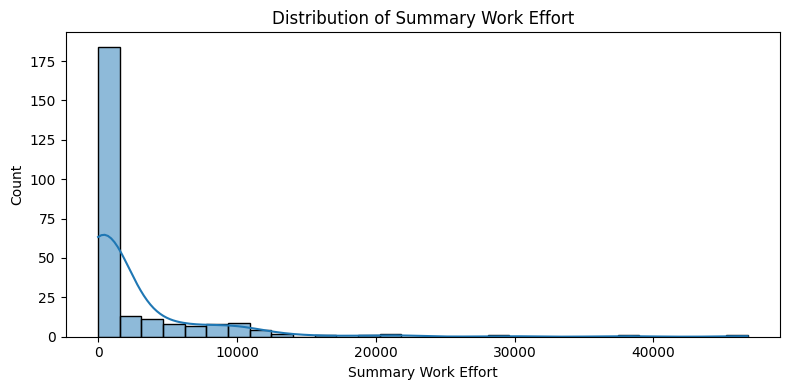

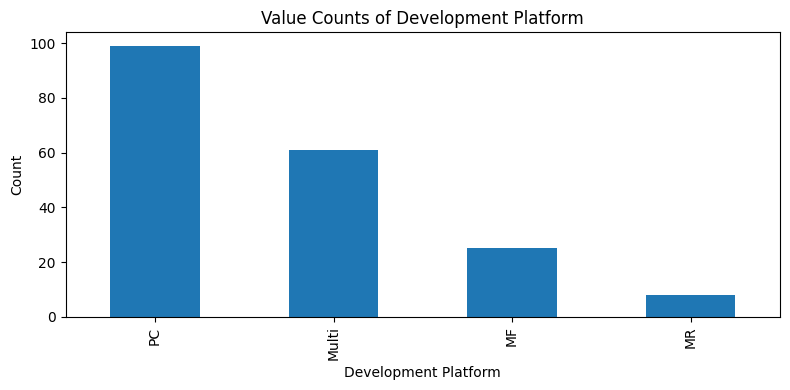

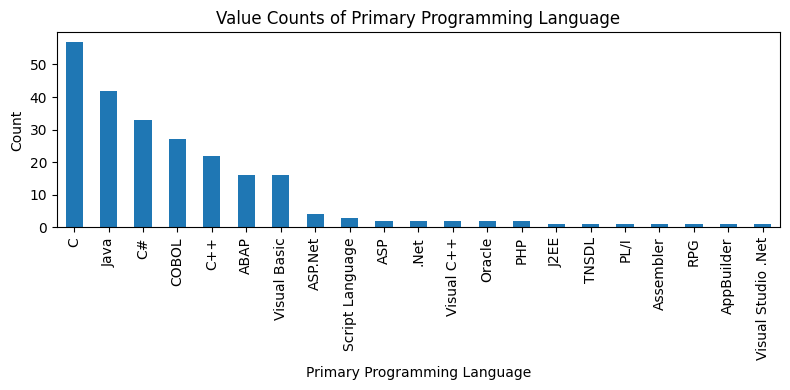

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_clean.select_dtypes(include=['object']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_clean[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df_clean[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


|Most of them are very skewed ==> First log transforrm, then scale
I will not log transform PET at first, as it is not skewed. I will only scale it  

One hot-encode categorical  
For PPL, gorup everything from ASP.Net into other

In [37]:
from sklearn.model_selection import train_test_split
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer

X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=RANDOM_SEED
)

from scipy.stats import ks_2samp

stat, p = ks_2samp(y_train, y_test)
print(f'KS statistic: {stat:.4f}, p-value: {p:.4f}')


KS statistic: 0.1296, p-value: 0.4582


p-value not < than .05, not a significant difference between the distribution of the train and test

In [38]:
# Median imputation for numerical columns
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    median_value = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_value)
    X_test[col] = X_test[col].fillna(median_value)

# Mode imputation for categorical columns
for col in X_train.select_dtypes(include=['object']).columns:
    mode_value = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_value)
    X_test[col] = X_test[col].fillna(mode_value)

# Data Augmentation

# Combine X_train and y_train into one DataFrame
df_ctgan = X_train.copy()
df_ctgan["Summary Work Effort"] = y_train

# Step 2: Detect metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=df_ctgan)


# Step 3: Initialize CTGAN with pac=1 to avoid divisibility errors
"""synthesizer = CTGANSynthesizer(
    metadata=metadata,
    epochs=300,
    batch_size=64,
    embedding_dim=64,
    generator_lr=2e-4,
    discriminator_lr=2e-4,
    pac=1  
)

# Step 4: Fit the model
synthesizer.fit(df_ctgan)"""
synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_ctgan)

# Step 5: Sample synthetic data
synthetic_data = synthesizer.sample(num_rows=int(N_SYNTH_DATA*len(df_ctgan)))

# Step 6: Separate features and target for later transformation
X_synth = synthetic_data.drop(columns=["Summary Work Effort"])
y_synth = synthetic_data["Summary Work Effort"]

"""
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=df_ctgan,
    synthetic_data=synthetic_data,
    metadata=metadata
)

from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    df_ctgan,
    synthetic_data,
    metadata
)"""

"""numeric_cols = X_synth.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X_synth.select_dtypes(include=['object']).columns

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(X_synth[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    X_synth[col].value_counts().plot(kind='bar')
    plt.title(f'Value Counts of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

"""

# Log transformation for skewed numerical columns
skewed = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit", "Max Team Size"]
for col in skewed:
    X_train[col] = np.log1p(X_train[col])
    X_test[col] = np.log1p(X_test[col])
    X_synth[col] = np.log1p(X_synth[col])

# Log transform output variable
y_train = np.log1p(y_train)
y_synth = np.log1p(y_synth)
y_test = np.log1p(y_test)

# Min-max scaling for numerical columns
from sklearn.preprocessing import MinMaxScaler
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
X_synth[numeric_cols] = scaler.transform(X_synth[numeric_cols])

# Threshold: keep only the top N most frequent languages
top_langs = X_train['Primary Programming Language'].value_counts().nlargest(5).index

# Replace rare languages with 'Other' in both train and test
X_train['Primary Programming Language'] = X_train['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)
X_test['Primary Programming Language'] = X_test['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)

top_langs = X_train['Primary Programming Language'].value_counts().nlargest(5).index

# Replace rare languages with 'Other' in both train and test
X_synth['Primary Programming Language'] = X_synth['Primary Programming Language'].apply(
    lambda x: x if x in top_langs else 'Other'
)

X_train_aug = pd.concat([X_train, X_synth], ignore_index=True)
y_train_aug = pd.concat([y_train, y_synth], ignore_index=True)

# One-hot encoding for categorical columns
X_train = pd.get_dummies(X_train, drop_first=True)
X_train_aug = pd.get_dummies(X_train_aug, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align all sets to X_train (real training data is your feature standard)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_train_aug = X_train_aug.reindex(columns=X_train.columns, fill_value=0)

#Split into functioal and technical features
X_func_train = X_train[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_tech_train = X_train.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
X_func_test = X_test[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_tech_test = X_test.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])
X_func_train_aug = X_train_aug[["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"]]
X_tech_train_aug = X_train_aug.drop(columns=["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit"])

c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:144: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sdv\single_table\base.py:122: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


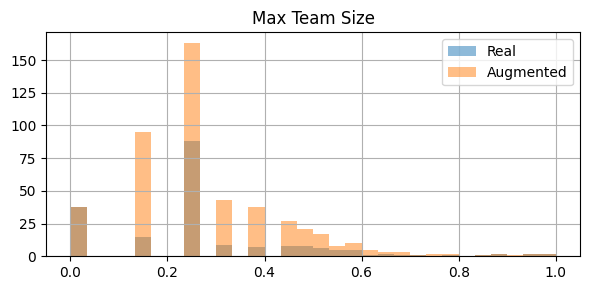

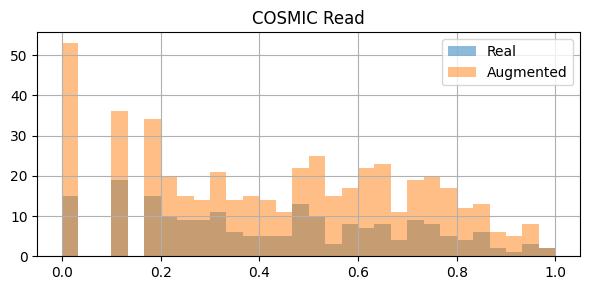

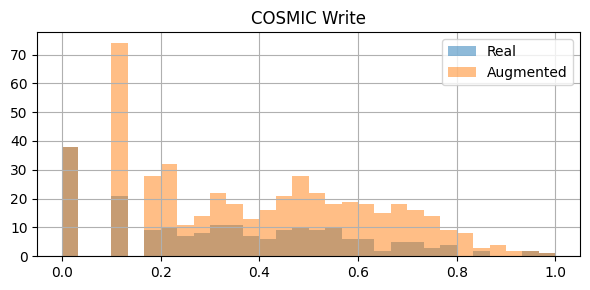

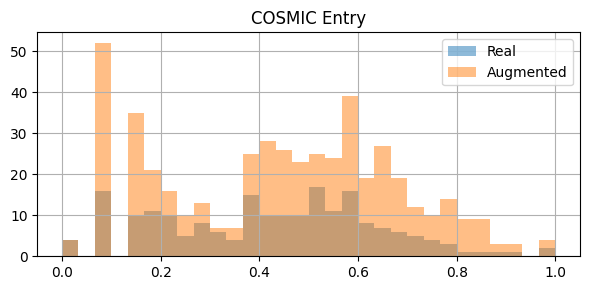

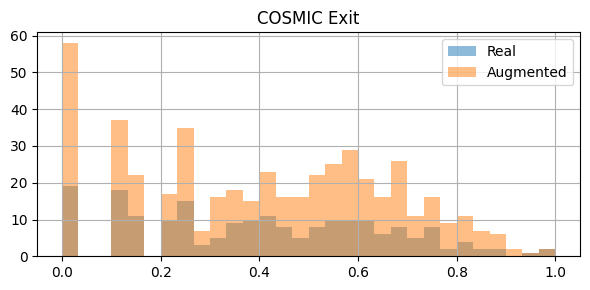

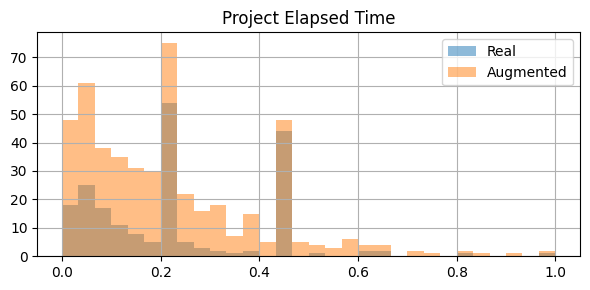

COSMIC Read: KS-stat=0.052, p=0.814
COSMIC Write: KS-stat=0.110, p=0.059
COSMIC Entry: KS-stat=0.084, p=0.247
COSMIC Exit: KS-stat=0.044, p=0.935
Max Team Size: KS-stat=0.110, p=0.059
Project Elapsed Time: KS-stat=0.086, p=0.224


In [39]:
import matplotlib.pyplot as plt

for col in X_train.columns:
    if X_train[col].dtype in ['float64', 'int64']:
        plt.figure(figsize=(6, 3))
        X_train[col].hist(alpha=0.5, bins=30, label='Real')
        X_train_aug[col].hist(alpha=0.5, bins=30, label='Augmented')
        plt.title(col)
        plt.legend()
        plt.tight_layout()
        plt.show()

for col in skewed + ["Project Elapsed Time"]:
    stat, p = ks_2samp(X_train[col], X_train_aug[col])
    print(f"{col}: KS-stat={stat:.3f}, p={p:.3f}")



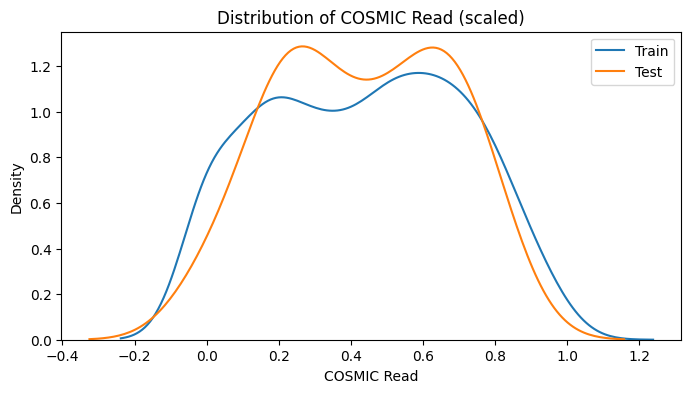

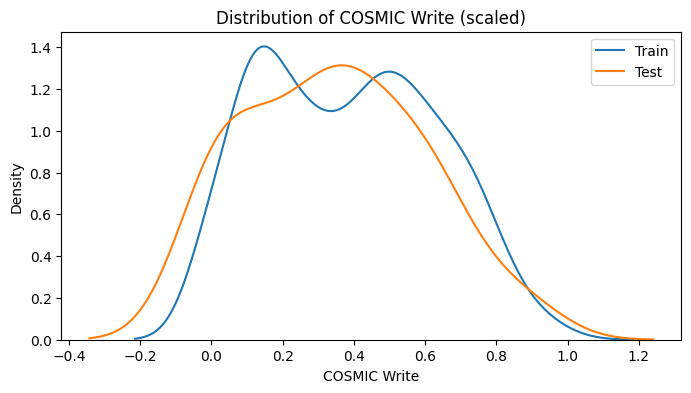

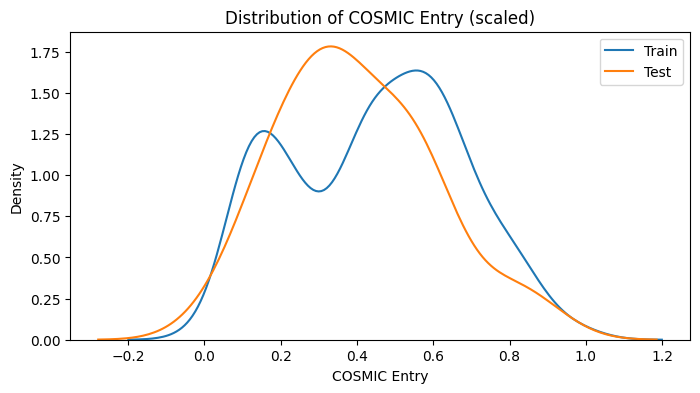

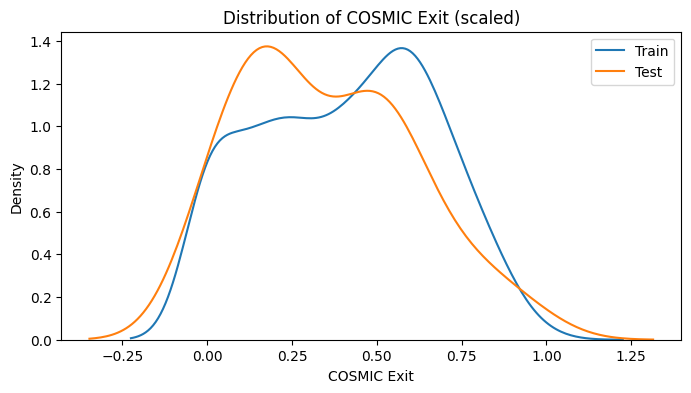

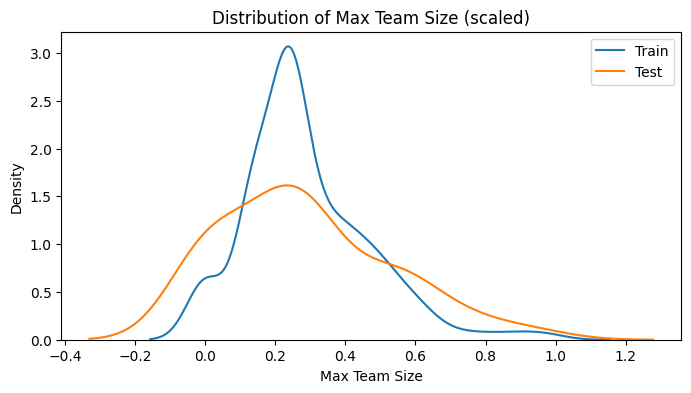

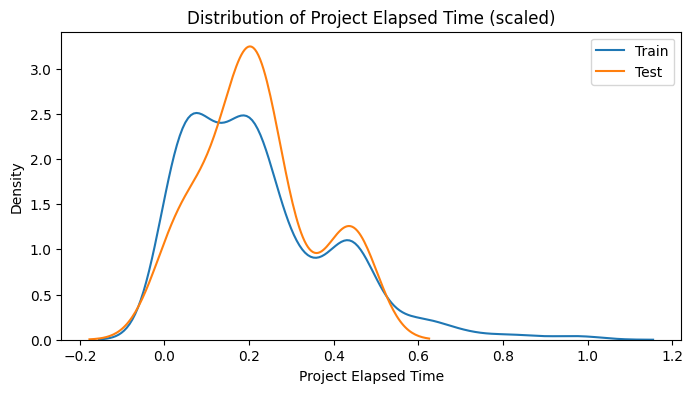

In [40]:
import matplotlib.pyplot as plt

def compare_feature_distribution(feature_name):
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train_aug[feature_name], label='Train')
    sns.kdeplot(X_test[feature_name], label='Test')
    plt.title(f'Distribution of {feature_name} (scaled)')
    plt.legend()
    plt.show()

compare_feature_distribution('COSMIC Read')
compare_feature_distribution('COSMIC Write')
compare_feature_distribution('COSMIC Entry')
compare_feature_distribution('COSMIC Exit')
compare_feature_distribution('Max Team Size')
compare_feature_distribution('Project Elapsed Time')

In [41]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Define scoring metrics
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error),
    'mmre': make_scorer(
        lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)),
        greater_is_better=False
    )
}

"""def pred_act(y_test,y_pred,label):
    plt.figure()
    plt.title(label)
    plt.scatter(y_test,y_pred)
    max_val = y_test.max()
    min_val = y_test.min()
    plt.plot([min_val,max_val],[min_val,max_val], 'r--',alpha=0.5,label=f"Perfect fit")
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    # plt.savefig(f"./res/plot/{label}_test_pred.png")
    plt.show()"""

def evaluate_model(X_train, y_train, X_test, y_test, model=None, label="",plot=False):
    if model is None:
        model = DecisionTreeRegressor(random_state=RANDOM_SEED)

    # Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=10, scoring=scoring, return_train_score=False)

    print(f"\n--- {label} (Cross-Validation on Train Set) ---")
    for metric in scoring:
        scores = cv_results[f'test_{metric}']
        print(f"{metric.upper()} (mean ± std): {scores.mean():.4f} ± {scores.std():.4f}")

    # Fit on full training set and evaluate on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n--- {label} (Test Set) ---")
    print(f"R2:  {r2_score(y_test, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
    mmre = np.mean(np.abs((y_test - y_pred) / y_test))
    print(f"MMRE: {mmre:.4f}")
    if plot:
        pred_act(y_test, y_pred, label)
    return

# Functional features only
evaluate_model(X_func_train, y_train, X_func_test, y_test, label="DTR Functional Approach")

# Technical features
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, label="DTR Technical Approach")

# Both
evaluate_model(X_train, y_train, X_test, y_test, label="DTR Combined")

# Augmented
evaluate_model(X_train_aug, y_train_aug, X_test, y_test, label="DTR AUGMENTED Combined",plot=False)




--- DTR Functional Approach (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.1972 ± 0.2555
MAE (mean ± std): 1.3450 ± 0.1467
MMRE (mean ± std): -0.2644 ± 0.0654

--- DTR Functional Approach (Test Set) ---
R2:  0.4143
MAE: 1.2278
MMRE: 0.2252

--- DTR Technical Approach (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6136 ± 0.1114
MAE (mean ± std): 0.8973 ± 0.1895
MMRE (mean ± std): -0.1878 ± 0.0712

--- DTR Technical Approach (Test Set) ---
R2:  0.7978
MAE: 0.7522
MMRE: 0.1548

--- DTR Combined (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6351 ± 0.1038
MAE (mean ± std): 0.9026 ± 0.1369
MMRE (mean ± std): -0.1804 ± 0.0549

--- DTR Combined (Test Set) ---
R2:  0.7743
MAE: 0.8059
MMRE: 0.1703

--- DTR AUGMENTED Combined (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.1247 ± 0.2773
MAE (mean ± std): 1.5015 ± 0.3328
MMRE (mean ± std): -0.3024 ± 0.0790

--- DTR AUGMENTED Combined (Test Set) ---
R2:  0.5681
MAE: 0.9510
MMRE: 0.1689


In [42]:
from sklearn.neural_network import MLPRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress only the convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define the MLPRegressor model (you can adjust the hyperparameters as needed)
mlp = MLPRegressor(hidden_layer_sizes=(50, 50), activation='tanh', solver='adam', max_iter=1000, random_state=RANDOM_SEED, early_stopping=False)

# Functional features only
evaluate_model(X_func_train, y_train,X_func_test, y_test, model=mlp, label="Functional Approach (MLP)")

# Technical features only
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=mlp, label="Technical Approach (MLP)")

# Technical features only
evaluate_model(X_train, y_train,X_test, y_test, model=mlp, label="Both MLP")

# Technical features only
evaluate_model(X_train_aug, y_train_aug, X_test, y_test, model=mlp, label="Both MLP Augmented")


--- Functional Approach (MLP) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5639 ± 0.1334
MAE (mean ± std): 1.0542 ± 0.1623
MMRE (mean ± std): -0.2173 ± 0.0639

--- Functional Approach (MLP) (Test Set) ---
R2:  0.5812
MAE: 1.2053
MMRE: 0.2142

--- Technical Approach (MLP) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6851 ± 0.0998
MAE (mean ± std): 0.8297 ± 0.1532
MMRE (mean ± std): -0.1933 ± 0.0849

--- Technical Approach (MLP) (Test Set) ---
R2:  0.7511
MAE: 0.8418
MMRE: 0.1749

--- Both MLP (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.8061 ± 0.0754
MAE (mean ± std): 0.6477 ± 0.1160
MMRE (mean ± std): -0.1400 ± 0.0579

--- Both MLP (Test Set) ---
R2:  0.8590
MAE: 0.6316
MMRE: 0.1207

--- Both MLP Augmented (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6006 ± 0.1757
MAE (mean ± std): 1.0496 ± 0.3128
MMRE (mean ± std): -0.2349 ± 0.0753

--- Both MLP Augmented (Test Set) ---
R2:  0.8729
MAE: 0.6145
MMRE: 0.1166


In [43]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define the XGBoost model
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror', 
    colsample_bytree=0.3, 
    learning_rate=0.6,
    max_depth=10, 
    alpha=10, 
    n_estimators=100, 
    verbosity=0, 
    random_state=RANDOM_SEED
)

# Evaluate functional approach with XGBoost
evaluate_model(X_func_train, y_train,X_func_test, y_test, model=xg_reg, label="Functional Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=xg_reg, label="Technical Approach (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_train, y_train,X_test, y_test, model=xg_reg, label="Both (XGBoost)")

# Evaluate technical approach with XGBoost
evaluate_model(X_train_aug, y_train_aug, X_test, y_test, model=xg_reg, label="Both (XGBoost) Augmented")

# Evaluate technical approach without Project Elapsed Time using XGBoost
evaluate_model(
    X_tech_train.drop(columns=['Project Elapsed Time']), 
    y_train,
    X_tech_test.drop(columns=['Project Elapsed Time']),
    y_test,
    model=xgb.XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.3,
        learning_rate=0.3,
        max_depth=10,
        alpha=10,
        n_estimators=100,
        verbosity=0,
        random_state=RANDOM_SEED
    ),
    label="Technical Approach w/o Project Elapsed Time (XGBoost)",
    # plot=False
)



--- Functional Approach (XGBoost) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5825 ± 0.1204
MAE (mean ± std): 1.0100 ± 0.1415
MMRE (mean ± std): -0.2035 ± 0.0518

--- Functional Approach (XGBoost) (Test Set) ---
R2:  0.6615
MAE: 1.0460
MMRE: 0.2006

--- Technical Approach (XGBoost) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6679 ± 0.0942
MAE (mean ± std): 0.8393 ± 0.1599
MMRE (mean ± std): -0.1896 ± 0.0793

--- Technical Approach (XGBoost) (Test Set) ---
R2:  0.7876
MAE: 0.7986
MMRE: 0.1704

--- Both (XGBoost) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.7362 ± 0.0553
MAE (mean ± std): 0.8035 ± 0.0693
MMRE (mean ± std): -0.1717 ± 0.0457

--- Both (XGBoost) (Test Set) ---
R2:  0.8755
MAE: 0.5949
MMRE: 0.1326

--- Both (XGBoost) Augmented (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5169 ± 0.2056
MAE (mean ± std): 1.1677 ± 0.3288
MMRE (mean ± std): -0.2524 ± 0.0818

--- Both (XGBoost) Augmented (Test Set) ---
R2:  0.8228
MAE: 0.7357
MMRE: 0.150

# GridSearchCV
- Initialize Gridsearch parameter search space ("The grid")

In [44]:
from sklearn.model_selection import GridSearchCV

# param_grid_dtr = {
#     'max_depth':      [None, 3,4, 5,6,7,8,9, 10],
#     'min_samples_split':  [2, 5, 10, 20],
#     'min_samples_leaf':   [1, 2, 4, 8],
# }

param_grid_dtr = {'max_depth': [3,6], 'min_samples_leaf': [2,4], 'min_samples_split': [2],}

# param_grid_xgb = {
#     'n_estimators':   [100, 200, 300,400,500],
#     'max_depth':      [None, 3,4, 5,6,7,8,9, 10],
#     'learning_rate':  [0.01, 0.1, 0.2],
#     'subsample':      [0.8, 1.0]
# }


param_grid_xgb = {'learning_rate': [0.01], 'max_depth': [3,5], 'n_estimators': [300,400], 'subsample': [0.8],}


# Gridsearch on the decision trees

In [45]:
# Decision Tree on tech features
grid_dtr_tech = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid=param_grid_dtr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_tech.fit(X_tech_train, y_train)

# Decision Tree on func features
grid_dtr_func = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid=param_grid_dtr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_func.fit(X_func_train, y_train)

# Decision Tree on all features (both functional + technical)
grid_dtr_both = GridSearchCV(
    DecisionTreeRegressor(random_state=RANDOM_SEED),
    param_grid=param_grid_dtr,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_both.fit(X_train, y_train)

# Print best parameters
print("Best DTR tech:", grid_dtr_tech.best_params_)
print("Best DTR func:", grid_dtr_func.best_params_)
print("Best DTR both:", grid_dtr_both.best_params_)

# Best estimators
best_dtr_tech = grid_dtr_tech.best_estimator_
best_dtr_func = grid_dtr_func.best_estimator_
best_dtr_both = grid_dtr_both.best_estimator_

# Evaluate models
print("\n=== Final performance (after grid search) ===")
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=best_dtr_func, label="DTR_func(GS)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=best_dtr_tech, label="DTR_tech(GS)")
evaluate_model(X_train, y_train, X_test, y_test, model=best_dtr_both, label="DTR_both(GS)")


Best DTR tech: {'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best DTR func: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best DTR both: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

=== Final performance (after grid search) ===

--- DTR_func(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5339 ± 0.1363
MAE (mean ± std): 1.0446 ± 0.0917
MMRE (mean ± std): -0.2096 ± 0.0534

--- DTR_func(GS) (Test Set) ---
R2:  0.6319
MAE: 1.0873
MMRE: 0.2037

--- DTR_tech(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6503 ± 0.1051
MAE (mean ± std): 0.8734 ± 0.2038
MMRE (mean ± std): -0.1878 ± 0.0772

--- DTR_tech(GS) (Test Set) ---
R2:  0.7862
MAE: 0.6940
MMRE: 0.1456

--- DTR_both(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.7196 ± 0.0664
MAE (mean ± std): 0.8290 ± 0.1159
MMRE (mean ± std): -0.1714 ± 0.0538

--- DTR_both(GS) (Test Set) ---
R2:  0.8359
MAE: 0.7547
MMRE: 0.1604


# GridSearchCV on XGB

In [46]:
# XGB on tech features
grid_xgb_tech = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_tech.fit(X_tech_train, y_train)

# XGB on func features
grid_xgb_func = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_func.fit(X_func_train, y_train)

# XGB on all features (both functional + technical)
grid_xgb_both = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=RANDOM_SEED),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_both.fit(X_train, y_train)

# Print best parameters
print("Best XGB tech:", grid_xgb_tech.best_params_)
print("Best XGB func:", grid_xgb_func.best_params_)
print("Best XGB both:", grid_xgb_both.best_params_)

# Best estimators
best_xgb_tech = grid_xgb_tech.best_estimator_
best_xgb_func = grid_xgb_func.best_estimator_
best_xgb_both = grid_xgb_both.best_estimator_

# Evaluate models
print("\n=== Final performance (after grid search) ===")
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=best_xgb_func, label="XGB_func(GS)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=best_xgb_tech, label="XGB_tech(GS)")
evaluate_model(X_train, y_train, X_test, y_test, model=best_xgb_both, label="XGB_both(GS)")


Best XGB tech: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 400, 'subsample': 0.8}
Best XGB func: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best XGB both: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.8}

=== Final performance (after grid search) ===

--- XGB_func(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5814 ± 0.1254
MAE (mean ± std): 0.9775 ± 0.1199
MMRE (mean ± std): -0.2004 ± 0.0505

--- XGB_func(GS) (Test Set) ---
R2:  0.6843
MAE: 1.0139
MMRE: 0.1973

--- XGB_tech(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.7170 ± 0.0827
MAE (mean ± std): 0.7597 ± 0.1540
MMRE (mean ± std): -0.1691 ± 0.0762

--- XGB_tech(GS) (Test Set) ---
R2:  0.8406
MAE: 0.6322
MMRE: 0.1389

--- XGB_both(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.7813 ± 0.0527
MAE (mean ± std): 0.7014 ± 0.0874
MMRE (mean ± std): -0.1514 ± 0.0493

--- XGB_both(GS) (Test Set) ---
R2:  0.8991
MAE: 0.5622
MMR

# GridSearchCV on MLP
- Define search space and perform Gridsearch

In [47]:
# param_grid_mlp = [
#     {
#       'solver': ['adam'],
#       'hidden_layer_sizes': [
#          (8,), (16,), (32,), (64,),            # 1layer
#          (8,8), (16,16), (32,16), (16,32),     # two-layer nets
#          (16,8,4), (32,16,8)                   # three-layer nets
#       ],
#       'activation':     ['relu'],
#       'alpha':          [ 1e-5, 1e-4, 1e-2],
#       'learning_rate':  ['constant', 'invscaling', 'adaptive'],
#       'learning_rate_init':  [1e-3, 1e-2],
#       'batch_size':     [8, 16,32],
#       'early_stopping': [True],               # against overfit..
#       'validation_fraction': [0.1, 0.2]
#     },
# ]

# Best results
param_grid_mlp = [

    {
      'solver': ['adam'],
      'hidden_layer_sizes': [ (32,16,8)                   # three-layer nets
      ],
      'activation':     ['relu'],
      'alpha':          [1e-2],
      'learning_rate':  ['constant'],
      'learning_rate_init':  [1e-3],
      'batch_size':     [8, 16],
      'early_stopping': [True],               # against overfit..
      'validation_fraction': [0.1]
    },
]

In [48]:
# MLP on tech features
grid_mlp_tech = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True
)
grid_mlp_tech.fit(X_tech_train, y_train)

print("Best MAE (neg) - tech:", grid_mlp_tech.best_score_)
print("Best hyperparameters - tech:", grid_mlp_tech.best_params_)
best_mlp_tech = grid_mlp_tech.best_estimator_

# MLP on func features
grid_mlp_func = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True
)
grid_mlp_func.fit(X_func_train, y_train)

print("Best MAE (neg) - func:", grid_mlp_func.best_score_)
print("Best hyperparameters - func:", grid_mlp_func.best_params_)
best_mlp_func = grid_mlp_func.best_estimator_

# MLP on both features
grid_mlp_both = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid_mlp,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_jobs=-1,
    verbose=2,
    refit=True
)
grid_mlp_both.fit(X_train, y_train)

print("Best MAE (neg) - both:", grid_mlp_both.best_score_)
print("Best hyperparameters - both:", grid_mlp_both.best_params_)
best_mlp_both = grid_mlp_both.best_estimator_

# Evaluate all
print("\n=== Final performance (after grid search) ===")
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=best_mlp_func, label="MLP_func(GS)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=best_mlp_tech, label="MLP_tech(GS)")
evaluate_model(X_train, y_train, X_test, y_test, model=best_mlp_both, label="MLP_both(GS)")


Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best MAE (neg) - tech: -0.9052335368719717
Best hyperparameters - tech: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 8, 'early_stopping': True, 'hidden_layer_sizes': (32, 16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam', 'validation_fraction': 0.1}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best MAE (neg) - func: -1.0370737363762688
Best hyperparameters - func: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 8, 'early_stopping': True, 'hidden_layer_sizes': (32, 16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'adam', 'validation_fraction': 0.1}
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best MAE (neg) - both: -0.6958088299374638
Best hyperparameters - both: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 16, 'early_stopping': True, 'hidden_layer_sizes': (32, 16, 8), 'learning_rate': 'constant', 'learning_rate_init': 0.

# Plot training curves
You might be able to explain over/underfit using this

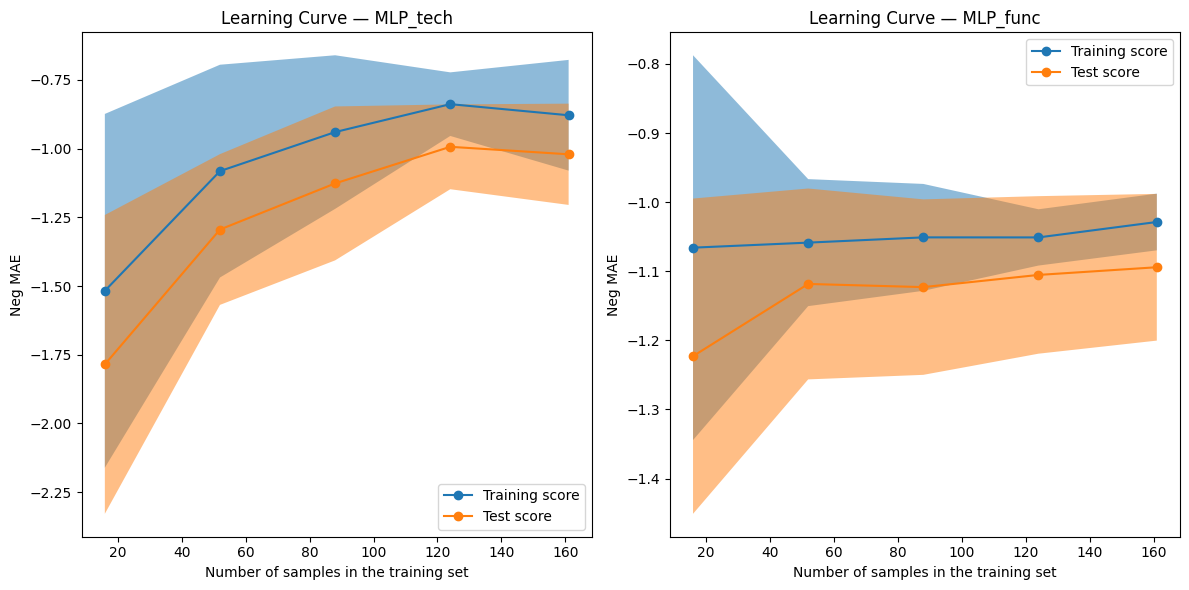

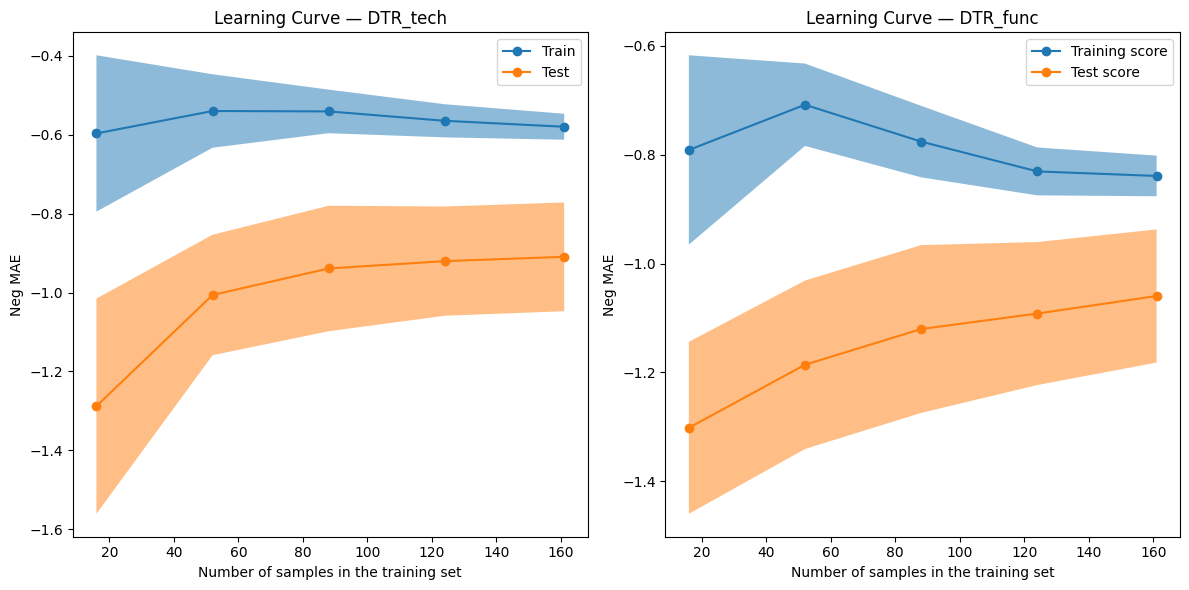

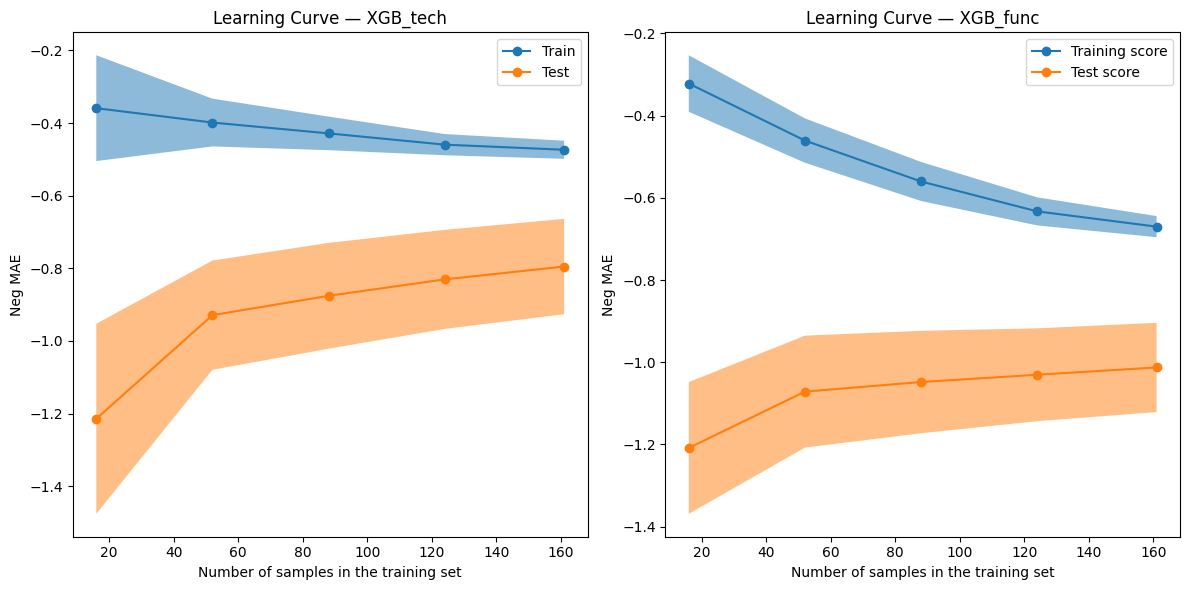

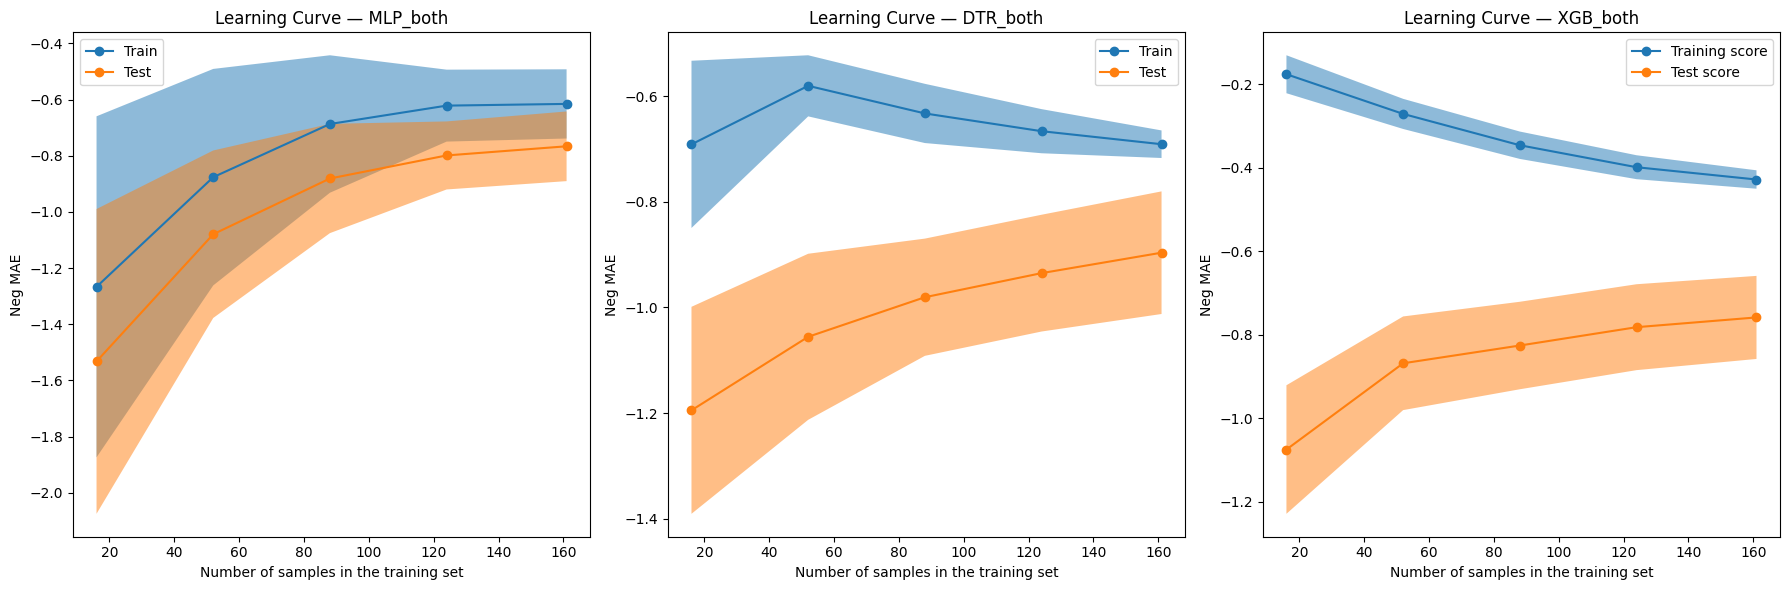

In [58]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

best_tech = grid_mlp_tech.best_estimator_
best_func = grid_mlp_func.best_estimator_

# Common settings
train_sizes = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "train_sizes": train_sizes,
    "cv": cv,
    "scoring": "neg_mean_absolute_error",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_type": "both",        # plot train & test
    "score_name": "Neg MAE",     # label in legend
}

# Left: tech‐only MLP
LearningCurveDisplay.from_estimator(
    best_tech,
    X=X_tech_train,
    y=y_train,
    **common_params,
    ax=axes[0]
)
axes[0].legend(["Training score", "Test score"])
axes[0].set_title("Learning Curve — MLP_tech")

# Right: func‐only MLP
LearningCurveDisplay.from_estimator(
    best_func,
    X=X_func_train,
    y=y_train,
    **common_params,
    ax=axes[1]
)
axes[1].legend(["Training score", "Test score"])
axes[1].set_title("Learning Curve — MLP_func")

plt.tight_layout()

# plt.savefig("./res/plots/LearningCurveMLP.png")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# left: Decision Tree on tech features
LearningCurveDisplay.from_estimator(
    best_dtr_tech,
    X=X_tech_train,
    y=y_train,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — DTR_tech")

# right: Decision Tree on func features
LearningCurveDisplay.from_estimator(
    best_dtr_func,
    X=X_func_train,
    y=y_train,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — DTR_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_DTR.png")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#left: XGBoost on tech features
LearningCurveDisplay.from_estimator(
    best_xgb_tech,
    X=X_tech_train,
    y=y_train,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — XGB_tech")

# Bottom‐right: XGBoost on func features
LearningCurveDisplay.from_estimator(
    best_xgb_func,
    X=X_func_train,
    y=y_train,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — XGB_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_XGB.png")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# MLP on all features
LearningCurveDisplay.from_estimator(
    best_mlp_both,
    X=X_train,
    y=y_train,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — MLP_both")

# Decision Tree on all features
LearningCurveDisplay.from_estimator(
    best_dtr_both,
    X=X_train,
    y=y_train,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — DTR_both")

# XGBoost on all features
LearningCurveDisplay.from_estimator(
    best_xgb_both,
    X=X_train,
    y=y_train,
    **common_params,
    ax=axes[2]
)
axes[2].set_title("Learning Curve — XGB_both")

axes[2].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_Both.png")
plt.show()


# Feature importance

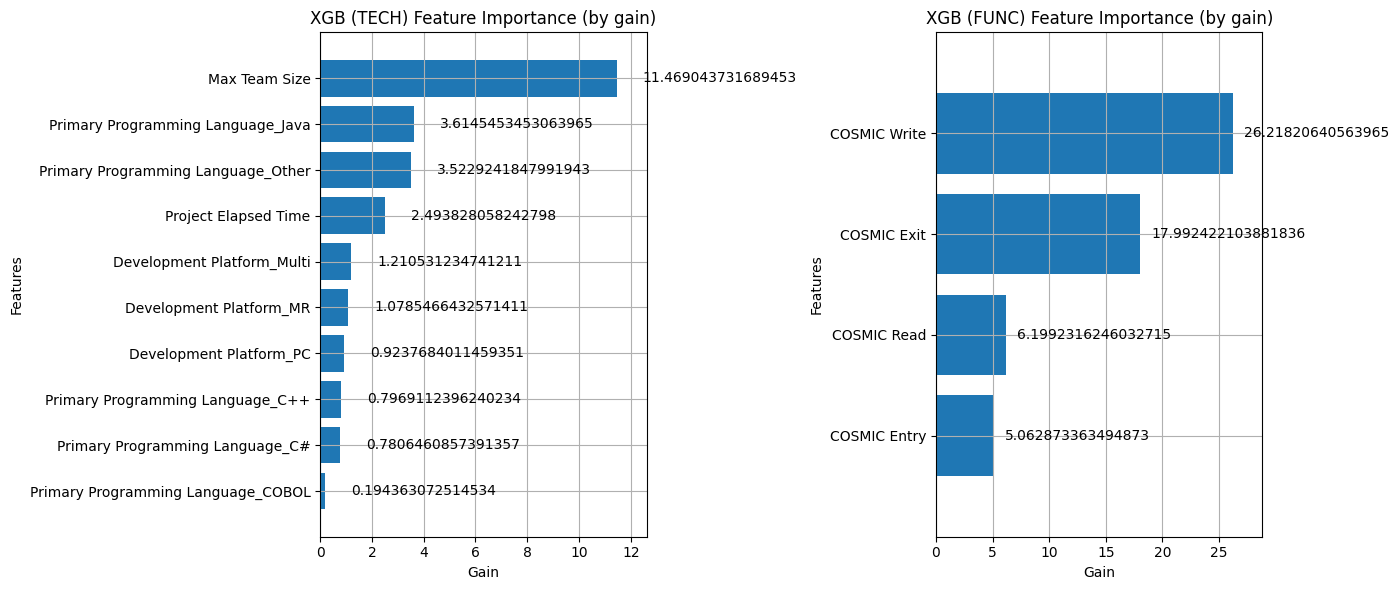

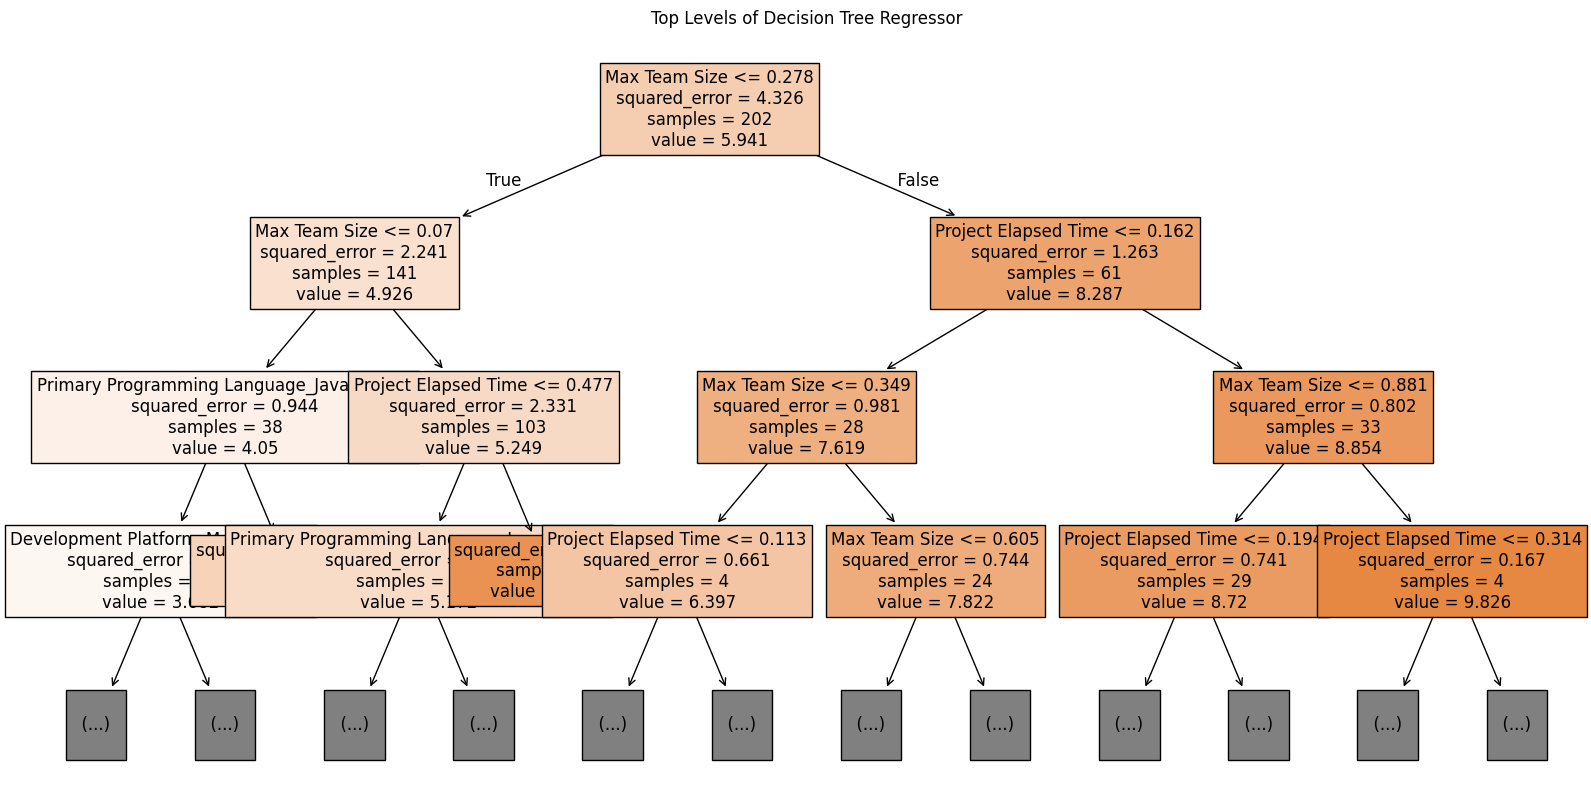

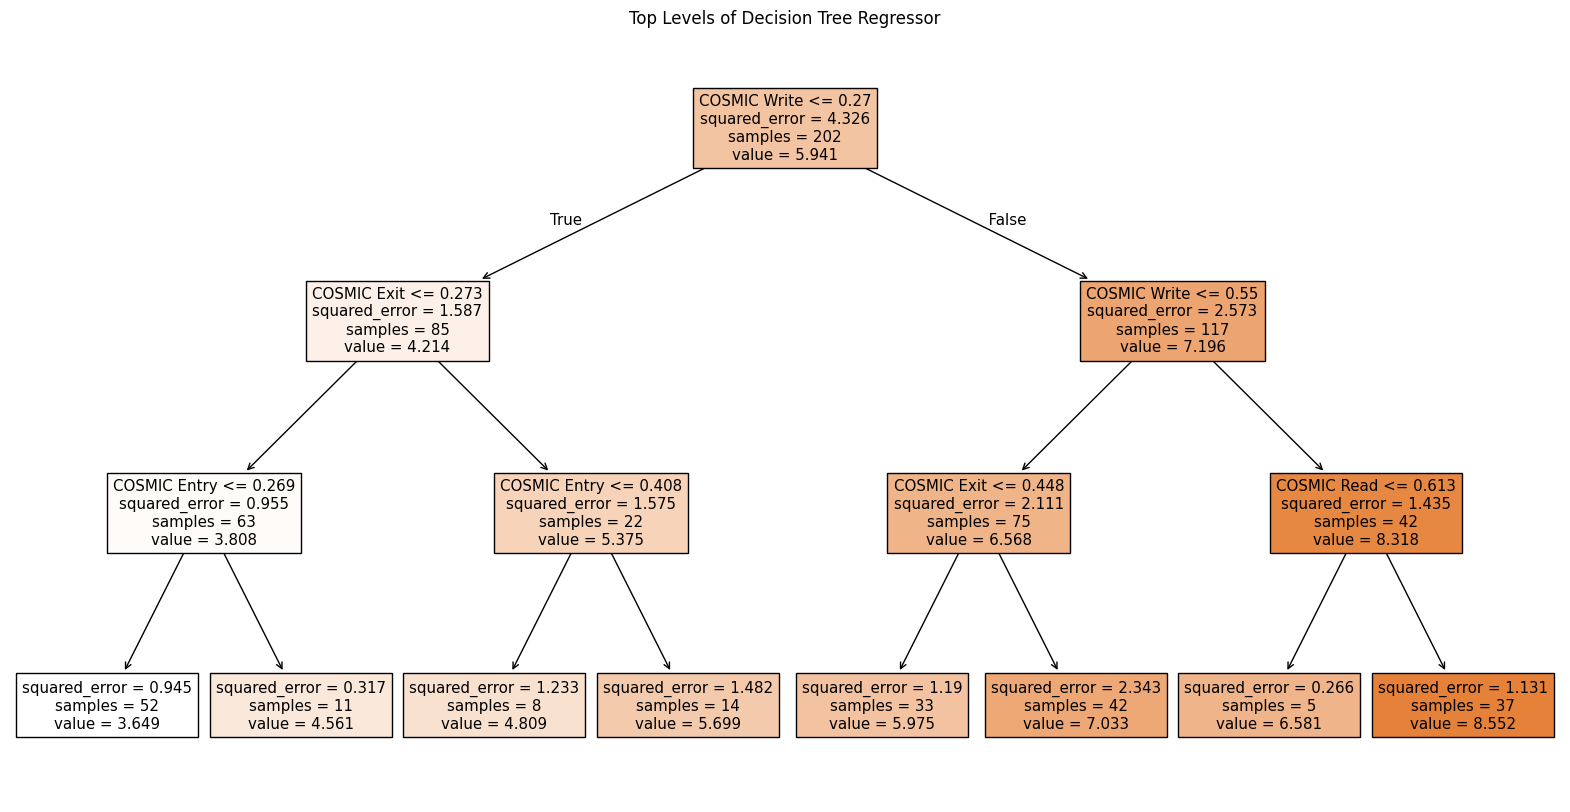

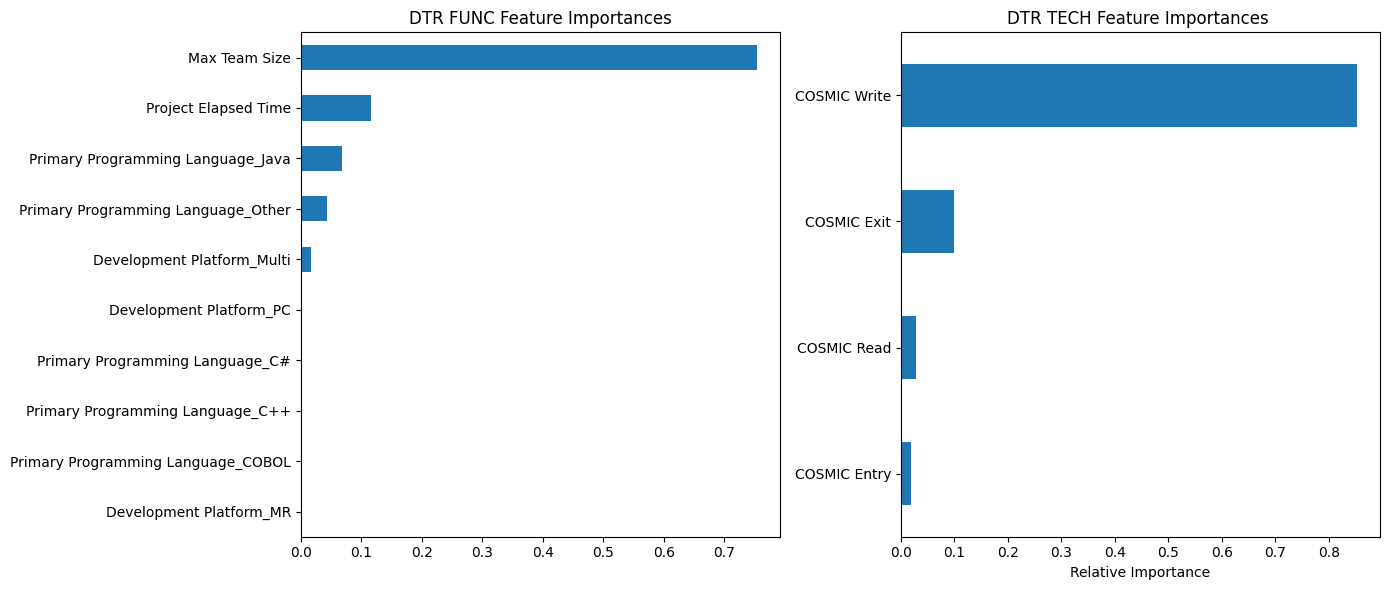

In [50]:
from xgboost import plot_importance, plot_tree

# Create a 1×2 grid of axes
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Left: TECH model
plot_importance(
    best_xgb_tech,
    ax=axes[0],
    importance_type='gain',  # average gain of splits
    max_num_features=20,  # show top 20 features
    height=0.8,  # bar height
)
axes[0].set_title("XGB (TECH) Feature Importance (by gain)")
axes[0].set_xlabel("Gain")
axes[0].set_ylabel("Features")

# Right: FUNC model
plot_importance(
    best_xgb_func,
    ax=axes[1],
    importance_type='gain',
    max_num_features=20,
    height=0.8,
)
axes[1].set_title("XGB (FUNC) Feature Importance (by gain)")
axes[1].set_xlabel("Gain")

plt.tight_layout()
#plt.savefig("./res/plots/XGBFeatureImportance.png")
plt.show()

from sklearn import tree

fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    best_dtr_tech,
    feature_names=best_dtr_tech.feature_names_in_,
    filled=True,  # color nodes by target value
    max_depth=3,
    fontsize=12,
    ax=ax
)
plt.title("Top Levels of Decision Tree Regressor")
#plt.savefig("./res/plots/DTRfuncTree.png")
plt.show()
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(
    best_dtr_func,
    feature_names=best_dtr_func.feature_names_in_,
    filled=True,  # color nodes by target value
    max_depth=3,  # show only top 3 levels for clarity
    ax=ax
)
plt.title("Top Levels of Decision Tree Regressor")
#plt.savefig("./res/plots/DTRfuncTree.png")
plt.show()

imp_func = (
    pd.Series(best_dtr_func.feature_importances_, index=X_func_train.columns)
    .sort_values(ascending=True)
)
imp_tech = (
    pd.Series(best_dtr_tech.feature_importances_, index=X_tech_train.columns)
    .sort_values(ascending=True)
)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

#  func importances
imp_func.plot.barh(ax=axes[1])
axes[0].set_title("DTR FUNC Feature Importances")
axes[0].set_xlabel("Relative Importance")

#  tech importances
imp_tech.plot.barh(ax=axes[0])
axes[1].set_title("DTR TECH Feature Importances ")
axes[1].set_xlabel("Relative Importance")

plt.tight_layout()
#plt.savefig("./res/plots/DTRFeatureImportance.png")
plt.show()



Using 202 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 202/202 [00:24<00:00,  8.23it/s]


-------- Shap MLP tech and Func --------
MLP TECH


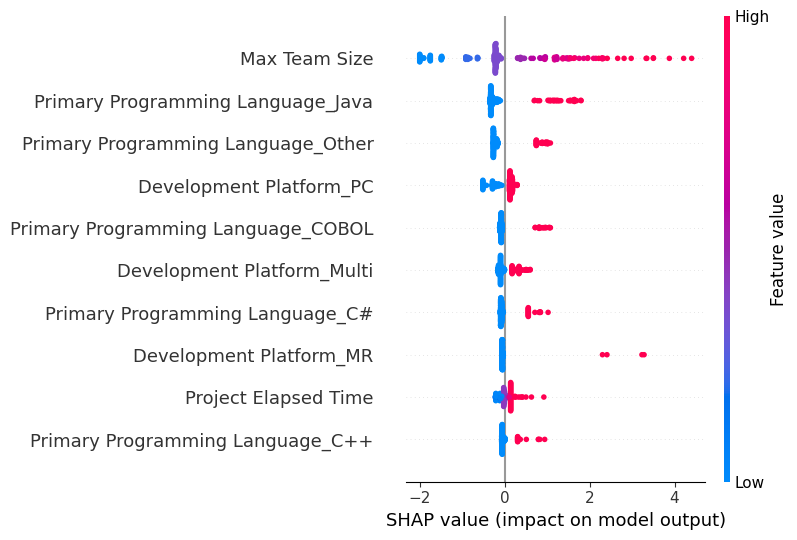

Using 202 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 202/202 [00:00<00:00, 514.96it/s]


MLP FUNC


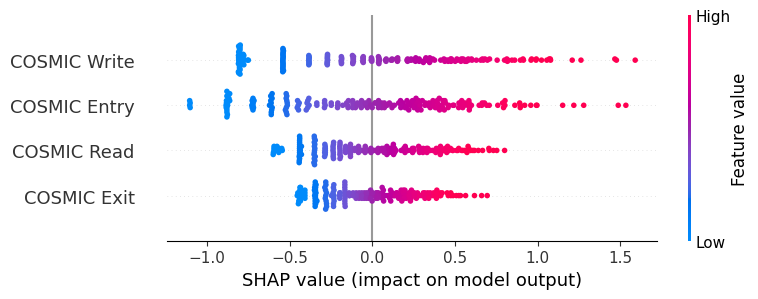

In [51]:
import shap

# fit a SHAP explainer on the tech MLP

explainer_tech = shap.KernelExplainer(best_mlp_tech.predict, X_tech_train.values)
shap_values_tech = explainer_tech.shap_values(X_tech_train.values)

# summary plot (global view)
print(f"{"--"*4} Shap MLP tech and Func {"--"*4}")
print(f"MLP TECH")
shap.summary_plot(shap_values_tech, X_tech_train, title="Shap values MLP TECH")

explainer_func = shap.KernelExplainer(best_mlp_func.predict, X_func_train.values)
shap_values_func = explainer_func.shap_values(X_func_train.values)
print(f"MLP FUNC")
shap.summary_plot(shap_values_func, X_func_train, title="Shap values MLP FUNC")


-------- Shap XGB tech and Func --------


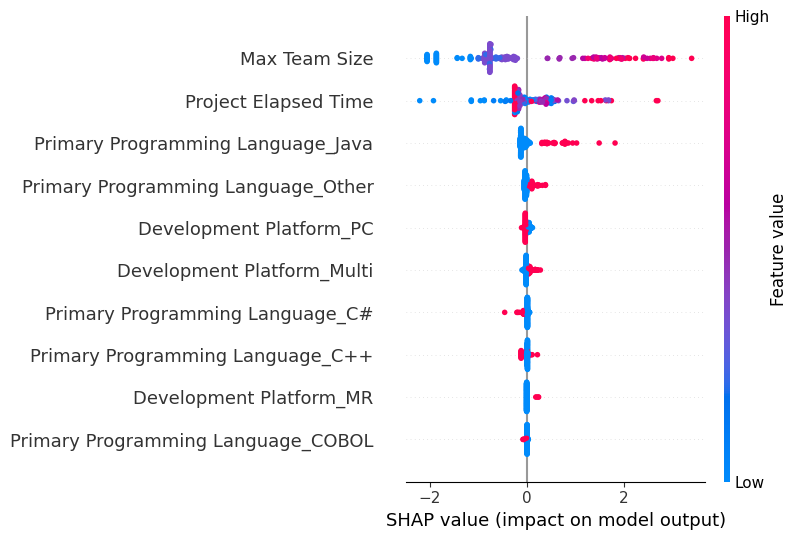

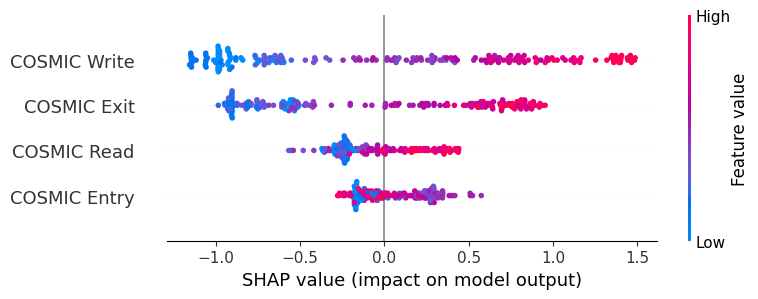

In [52]:
print(f"{"--"*4} Shap XGB tech and Func {"--"*4}")

explainer_tech = shap.TreeExplainer(best_xgb_tech)
shap_values_tech = explainer_tech.shap_values(X_tech_train)
shap.summary_plot(shap_values_tech, X_tech_train, title="Shap values XGB TECH")

explainer_func = shap.TreeExplainer(best_xgb_func)
shap_values_func = explainer_func.shap_values(X_func_train)
shap.summary_plot(shap_values_func, X_func_train, title="Shap values XGB FUNC")


-------- Shap DTR tech and Func --------


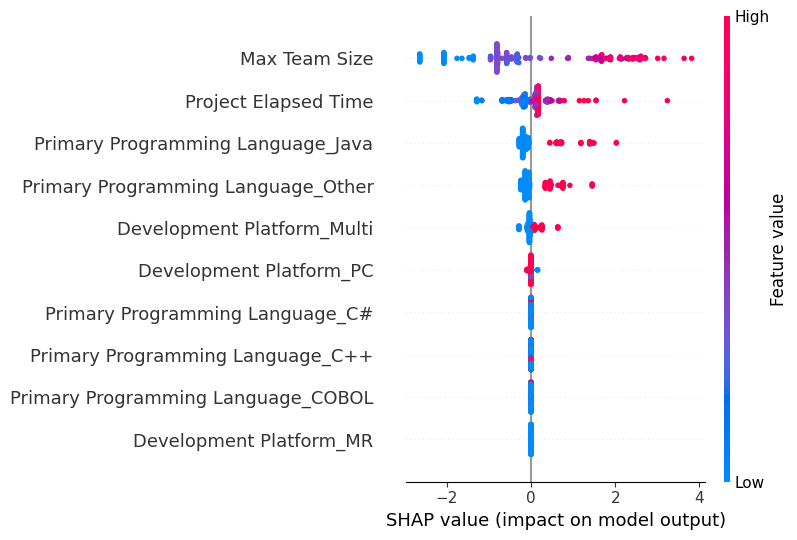

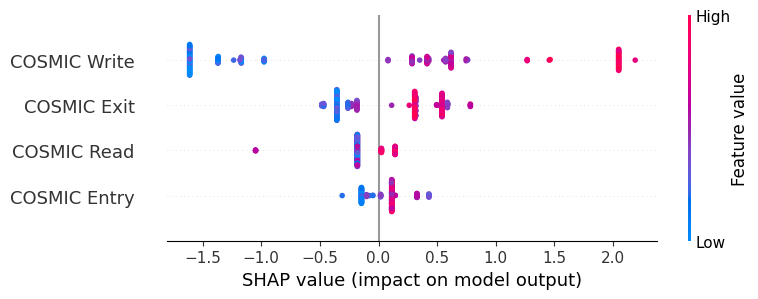

In [53]:
print(f"{"--"*4} Shap DTR tech and Func {"--"*4}")
explainer_tech = shap.TreeExplainer(best_dtr_tech)
shap_values_tech = explainer_tech.shap_values(X_tech_train)
shap.summary_plot(shap_values_tech, X_tech_train, title="Shap values DTR TECH")

explainer_func = shap.TreeExplainer(best_dtr_func)
shap_values_func = explainer_func.shap_values(X_func_train)
shap.summary_plot(shap_values_func, X_func_train, title="Shap values DTR FUNC")

In [54]:

evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_mlp_func, label="MLP_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_mlp_func, label="MLP_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_mlp_tech, label="MLP_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_mlp_tech, label="MLP_tech (GS)- AUG")

evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_xgb_func, label="xgb_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_xgb_func, label="xgb_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_xgb_tech, label="xgb_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_xgb_tech, label="xgb_tech (GS) - AUG")

evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_dtr_func, label="dtr_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_dtr_func, label="dtr_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_dtr_tech, label="dtr_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_dtr_tech, label="dtr_tech (GS) - AUG")


--- MLP_func(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5582 ± 0.1487
MAE (mean ± std): 1.0484 ± 0.1631
MMRE (mean ± std): -0.2130 ± 0.0616

--- MLP_func(GS) (Test Set) ---
R2:  0.6093
MAE: 1.1606
MMRE: 0.2156

--- MLP_func(GS) - AUG (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.4094 ± 0.1770
MAE (mean ± std): 1.3246 ± 0.2597
MMRE (mean ± std): -0.2827 ± 0.0666

--- MLP_func(GS) - AUG (Test Set) ---
R2:  0.6125
MAE: 1.1514
MMRE: 0.2150

--- MLP_tech (GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6380 ± 0.1292
MAE (mean ± std): 0.9005 ± 0.2099
MMRE (mean ± std): -0.2027 ± 0.0865

--- MLP_tech (GS) (Test Set) ---
R2:  0.7990
MAE: 0.7515
MMRE: 0.1675

--- MLP_tech (GS)- AUG (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.4679 ± 0.1971
MAE (mean ± std): 1.2331 ± 0.3227
MMRE (mean ± std): -0.2909 ± 0.0880

--- MLP_tech (GS)- AUG (Test Set) ---
R2:  0.7152
MAE: 0.9185
MMRE: 0.2228

--- xgb_func(GS) (Cross-Validation on Train Set) ---
R2 (mean ± s

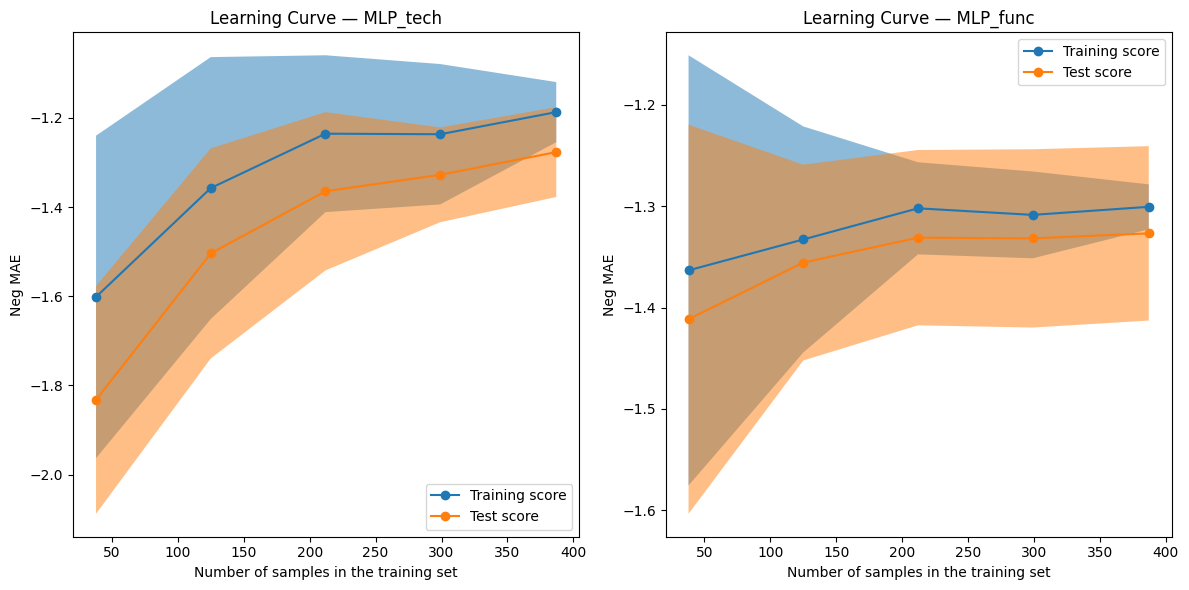

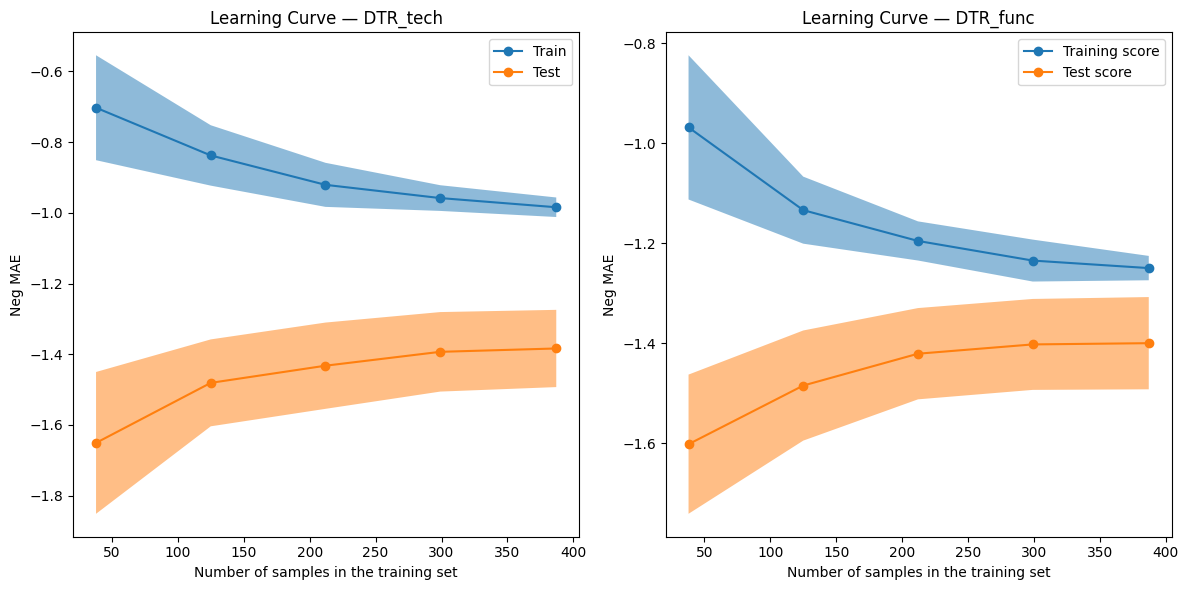

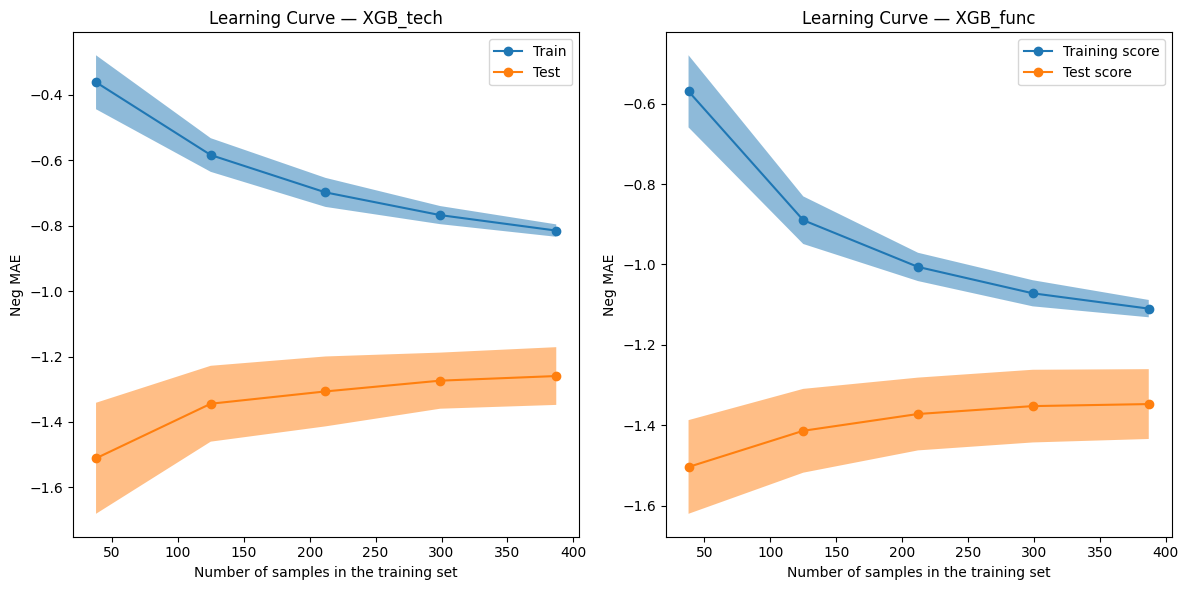

In [55]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

best_tech = grid_mlp_tech.best_estimator_
best_func = grid_mlp_func.best_estimator_
# Common settings
train_sizes = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "train_sizes": train_sizes,
    "cv": cv,
    "scoring": "neg_mean_absolute_error",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_type": "both",        # plot train & test
    "score_name": "Neg MAE",     # label in legend
}

# Left: tech‐only MLP
LearningCurveDisplay.from_estimator(
    best_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].legend(["Training score", "Test score"])
axes[0].set_title("Learning Curve — MLP_tech")

# Right: func‐only MLP
LearningCurveDisplay.from_estimator(
    best_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].legend(["Training score", "Test score"])
axes[1].set_title("Learning Curve — MLP_func")

plt.tight_layout()

# plt.savefig("./res/plots/LearningCurveMLP.png")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# left: Decision Tree on tech features
LearningCurveDisplay.from_estimator(
    best_dtr_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — DTR_tech")

# right: Decision Tree on func features
LearningCurveDisplay.from_estimator(
    best_dtr_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — DTR_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_DTR.png")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#left: XGBoost on tech features
LearningCurveDisplay.from_estimator(
    best_xgb_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — XGB_tech")

# Bottom‐right: XGBoost on func features
LearningCurveDisplay.from_estimator(
    best_xgb_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — XGB_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_XGB.png")
plt.show()


# Below is 5*len as N_SYNTH_DATA
Issue is that Kolmogorov–Smirnov test for Max team size <<0.05;
I'd suggest that realism platteaus around 1.3 as KS >= 0.07 and 1.4 KS >= 0.059

In [59]:
# Put amount of synth data to 5*len
evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_mlp_func, label="MLP_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_mlp_func, label="MLP_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_mlp_tech, label="MLP_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_mlp_tech, label="MLP_tech (GS)- AUG")
evaluate_model(X_train, y_train,X_test, y_test, model=best_mlp_both, label="MLP_both (GS)")
evaluate_model(X_train_aug, y_train_aug,X_test, y_test, model=best_mlp_both, label="MLP_both (GS)- AUG")

evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_xgb_func, label="xgb_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_xgb_func, label="xgb_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_xgb_tech, label="xgb_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_xgb_tech, label="xgb_tech (GS) - AUG")
evaluate_model(X_train, y_train,X_test, y_test, model=best_xgb_both, label="XGB_both (GS)")
evaluate_model(X_train_aug, y_train_aug,X_test, y_test, model=best_xgb_both, label="XGB_both (GS)- AUG")

evaluate_model(X_func_train, y_train,X_func_test, y_test, model=best_dtr_func, label="dtr_func(GS)")
evaluate_model(X_func_train_aug, y_train_aug,X_func_test, y_test, model=best_dtr_func, label="dtr_func(GS) - AUG")
evaluate_model(X_tech_train, y_train,X_tech_test, y_test, model=best_dtr_tech, label="dtr_tech (GS)")
evaluate_model(X_tech_train_aug, y_train_aug,X_tech_test, y_test, model=best_dtr_tech, label="dtr_tech (GS) - AUG")
evaluate_model(X_train, y_train,X_test, y_test, model=best_dtr_both, label="DTR_both (GS)")
evaluate_model(X_train_aug, y_train_aug,X_test, y_test, model=best_dtr_both, label="DTR_both (GS)- AUG")

# Default models
def_dt=DecisionTreeRegressor(random_state=42)
def_mlp=MLPRegressor(random_state=42)
def_xgb=xgb.XGBRegressor(random_states=42)

# Evaluate default MLP
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=def_mlp, label="MLP_func (Default)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=def_mlp, label="MLP_tech (Default)")
evaluate_model(X_train, y_train, X_test, y_test, model=def_mlp, label="MLP_both (Default)")

# Evaluate default XGBoost
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=def_xgb, label="XGB_func (Default)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=def_xgb, label="XGB_tech (Default)")
evaluate_model(X_train, y_train, X_test, y_test, model=def_xgb, label="XGB_both (Default)")

# Evaluate default Decision Tree
evaluate_model(X_func_train, y_train, X_func_test, y_test, model=def_dt, label="DTR_func (Default)")
evaluate_model(X_tech_train, y_train, X_tech_test, y_test, model=def_dt, label="DTR_tech (Default)")
evaluate_model(X_train, y_train, X_test, y_test, model=def_dt, label="DTR_both (Default)")




--- MLP_func(GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.5582 ± 0.1487
MAE (mean ± std): 1.0484 ± 0.1631
MMRE (mean ± std): -0.2130 ± 0.0616

--- MLP_func(GS) (Test Set) ---
R2:  0.6093
MAE: 1.1606
MMRE: 0.2156

--- MLP_func(GS) - AUG (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.4094 ± 0.1770
MAE (mean ± std): 1.3246 ± 0.2597
MMRE (mean ± std): -0.2827 ± 0.0666

--- MLP_func(GS) - AUG (Test Set) ---
R2:  0.6125
MAE: 1.1514
MMRE: 0.2150

--- MLP_tech (GS) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6380 ± 0.1292
MAE (mean ± std): 0.9005 ± 0.2099
MMRE (mean ± std): -0.2027 ± 0.0865

--- MLP_tech (GS) (Test Set) ---
R2:  0.7990
MAE: 0.7515
MMRE: 0.1675

--- MLP_tech (GS)- AUG (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.4679 ± 0.1971
MAE (mean ± std): 1.2331 ± 0.3227
MMRE (mean ± std): -0.2909 ± 0.0880

--- MLP_tech (GS)- AUG (Test Set) ---
R2:  0.7152
MAE: 0.9185
MMRE: 0.2228

--- MLP_both (GS) (Cross-Validation on Train Set) ---
R2 (mean ± 

c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:48] WARNING: C:\actions-runner\_w


--- XGB_func (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.3818 ± 0.1856
MAE (mean ± std): 1.1363 ± 0.1481
MMRE (mean ± std): -0.2352 ± 0.0618

--- XGB_func (Default) (Test Set) ---
R2:  0.5929
MAE: 1.0425
MMRE: 0.1941


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:49] WARNING: C:\actions-runner\_w


--- XGB_tech (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6835 ± 0.0576
MAE (mean ± std): 0.8069 ± 0.1176
MMRE (mean ± std): -0.1748 ± 0.0687

--- XGB_tech (Default) (Test Set) ---
R2:  0.8211
MAE: 0.6616
MMRE: 0.1419


c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "random_states" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\maria\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:50] WARNING: C:\actions-runner\_w


--- XGB_both (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6717 ± 0.1083
MAE (mean ± std): 0.8517 ± 0.1328
MMRE (mean ± std): -0.1756 ± 0.0536

--- XGB_both (Default) (Test Set) ---
R2:  0.8715
MAE: 0.6139
MMRE: 0.1340

--- DTR_func (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.1972 ± 0.2555
MAE (mean ± std): 1.3450 ± 0.1467
MMRE (mean ± std): -0.2644 ± 0.0654

--- DTR_func (Default) (Test Set) ---
R2:  0.4143
MAE: 1.2278
MMRE: 0.2252

--- DTR_tech (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6136 ± 0.1114
MAE (mean ± std): 0.8973 ± 0.1895
MMRE (mean ± std): -0.1878 ± 0.0712

--- DTR_tech (Default) (Test Set) ---
R2:  0.7978
MAE: 0.7522
MMRE: 0.1548

--- DTR_both (Default) (Cross-Validation on Train Set) ---
R2 (mean ± std): 0.6351 ± 0.1038
MAE (mean ± std): 0.9026 ± 0.1369
MMRE (mean ± std): -0.1804 ± 0.0549

--- DTR_both (Default) (Test Set) ---
R2:  0.7743
MAE: 0.8059
MMRE: 0.1703


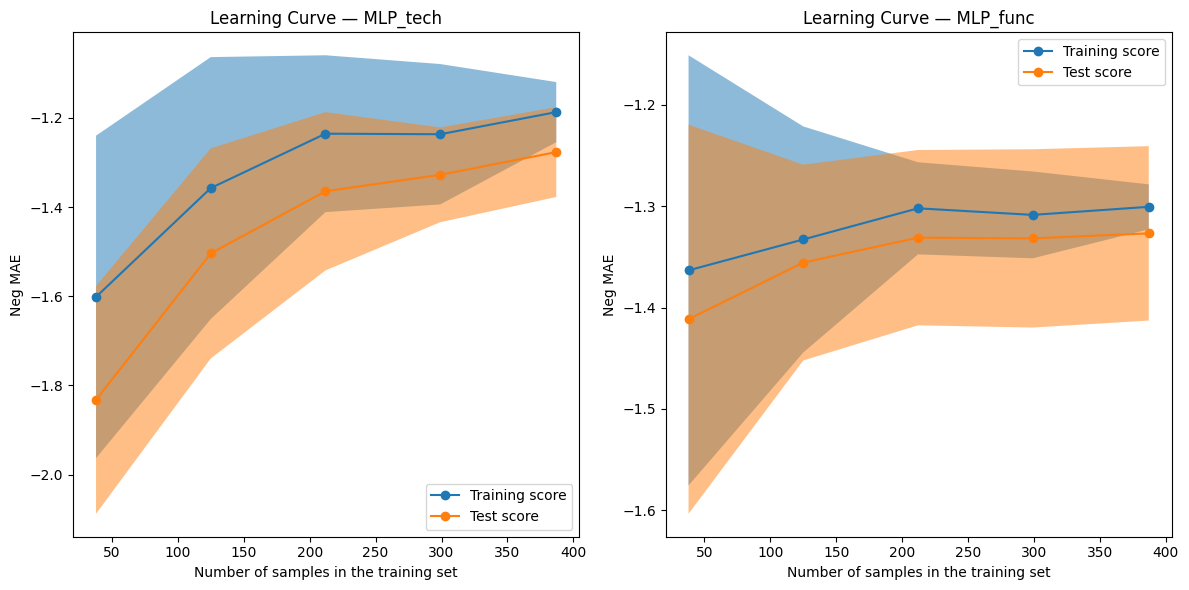

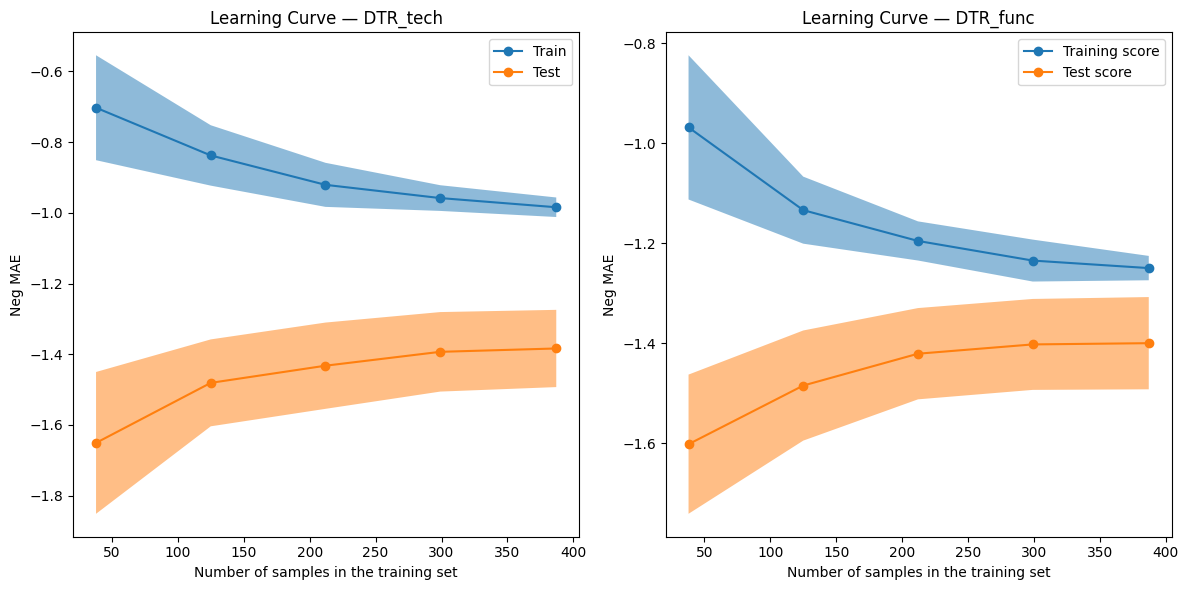

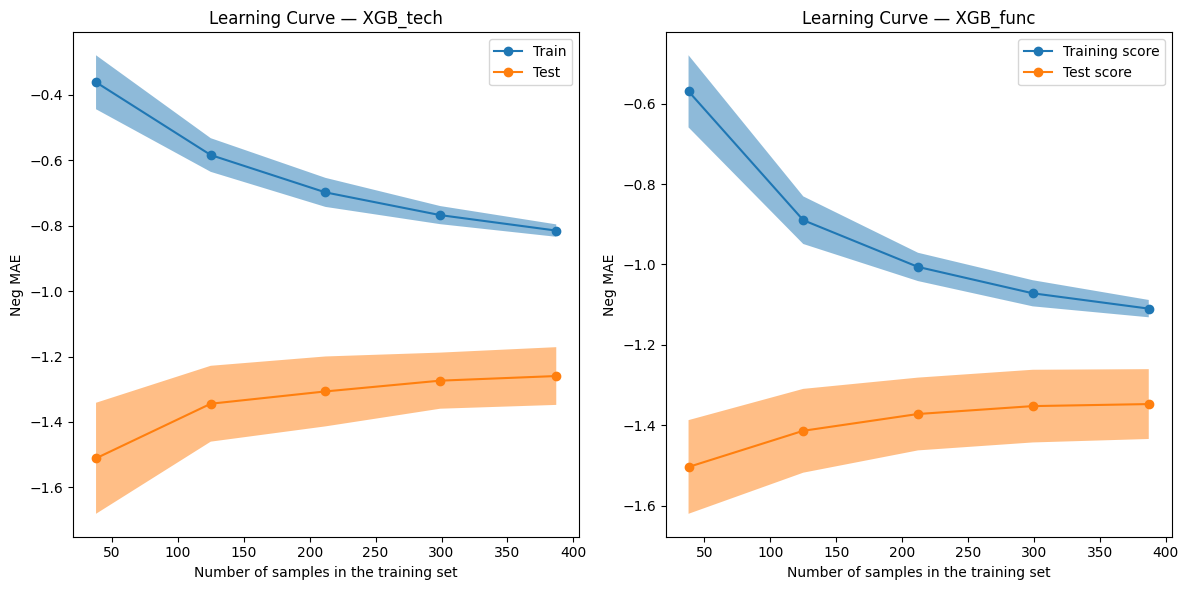

In [ ]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

best_tech = grid_mlp_tech.best_estimator_
best_func = grid_mlp_func.best_estimator_

# Common settings
train_sizes = np.linspace(0.1, 1.0, 5)
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=RANDOM_SEED)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

common_params = {
    "train_sizes": train_sizes,
    "cv": cv,
    "scoring": "neg_mean_absolute_error",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_type": "both",        # plot train & test
    "score_name": "Neg MAE",     # label in legend
}

# Left: tech‐only MLP
LearningCurveDisplay.from_estimator(
    best_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].legend(["Training score", "Test score"])
axes[0].set_title("Learning Curve — MLP_tech")

# Right: func‐only MLP
LearningCurveDisplay.from_estimator(
    best_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].legend(["Training score", "Test score"])
axes[1].set_title("Learning Curve — MLP_func")

plt.tight_layout()

# plt.savefig("./res/plots/LearningCurveMLP.png")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# left: Decision Tree on tech features
LearningCurveDisplay.from_estimator(
    best_dtr_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — DTR_tech")

# right: Decision Tree on func features
LearningCurveDisplay.from_estimator(
    best_dtr_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — DTR_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_DTR.png")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
#left: XGBoost on tech features
LearningCurveDisplay.from_estimator(
    best_xgb_tech,
    X=X_tech_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[0]
)
axes[0].set_title("Learning Curve — XGB_tech")

# Bottom‐right: XGBoost on func features
LearningCurveDisplay.from_estimator(
    best_xgb_func,
    X=X_func_train_aug,
    y=y_train_aug,
    **common_params,
    ax=axes[1]
)
axes[1].set_title("Learning Curve — XGB_func")

axes[1].legend(["Training score", "Test score"])
plt.tight_layout()
# plt.savefig("./res/plots/LearningCurve_XGB.png")
plt.show()
